# Overview
To see the summary, skip down to the bottom and scroll up to "Summary of Feature Importance", the text block above item 24. 

To see the entire process, start at item 1.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split

%matplotlib inline
plt.style.use('seaborn')

In [2]:
users = pd.read_csv('../data/raw/takehome_users.csv', encoding = "ISO-8859-1")
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Fill nas here with a timestamp for 2012-01-15, before any of the real ones
users.last_session_creation_time.fillna(1326652406.0, inplace=True);

In [4]:
eng = pd.read_csv('../data/raw/takehome_user_engagement.csv')
eng.info()
eng.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
users['domain'] = users.email.str.split('@').apply(lambda tup: tup[1])

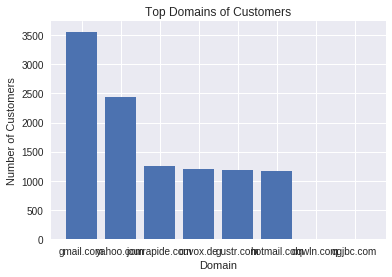

In [6]:
counts = users.domain.value_counts()

fig, ax = plt.subplots()
ax.bar(counts[:8].index, counts[:8].values)
ax.set_title('Top Domains of Customers')
ax.set_xlabel('Domain')
ax.set_ylabel('Number of Customers');

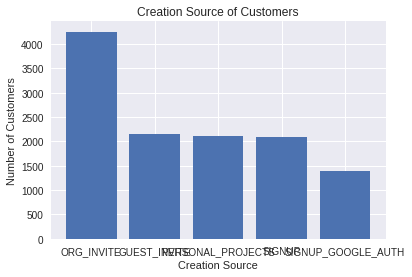

In [7]:
counts = users.creation_source.value_counts()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title('Creation Source of Customers')
ax.set_xlabel('Creation Source')
ax.set_ylabel('Number of Customers');

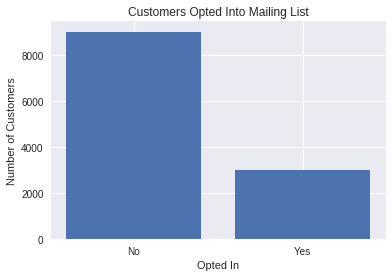

In [8]:
counts = users.opted_in_to_mailing_list.value_counts()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title('Customers Opted Into Mailing List')
ax.set_xlabel('Opted In')
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.set_xticklabels(['', 'No', 'Yes'])
ax.set_ylabel('Number of Customers');

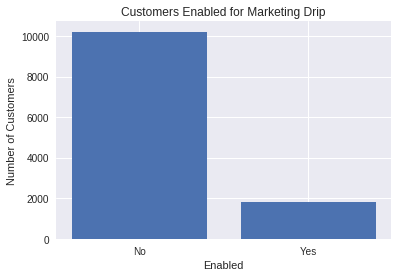

In [9]:
counts = users.enabled_for_marketing_drip.value_counts()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title('Customers Enabled for Marketing Drip')
ax.set_xlabel('Enabled')
ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.set_xticklabels(['', 'No', 'Yes'])
ax.set_ylabel('Number of Customers');

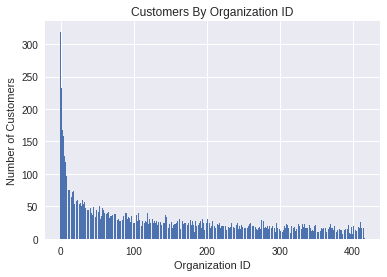

In [10]:
counts = users.org_id.value_counts()

fig, ax = plt.subplots()
plt.bar(counts.index, counts.values)
ax.set_title('Customers By Organization ID')
ax.set_xlabel('Organization ID')
ax.set_ylabel('Number of Customers');

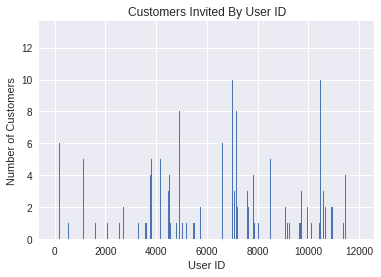

In [11]:
counts = users.invited_by_user_id.value_counts()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title('Customers Invited By User ID')
ax.set_xlabel('User ID')
ax.set_ylabel('Number of Customers');

In [12]:
users['creation'] = pd.to_datetime(users.creation_time)
del users['creation_time']
users['last_session'] = pd.to_datetime(users.last_session_creation_time * 1e9)
del users['last_session_creation_time']

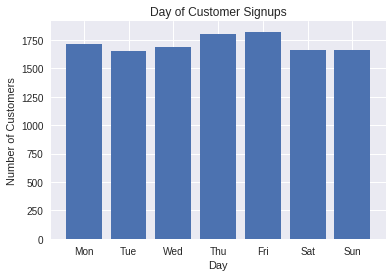

In [13]:
users['day_of_creation'] = users.creation.dt.dayofweek
counts = users.groupby('day_of_creation').name.count()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title('Day of Customer Signups')
ax.set_xlabel('Day')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xticklabels(['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_ylabel('Number of Customers');

del users['day_of_creation']

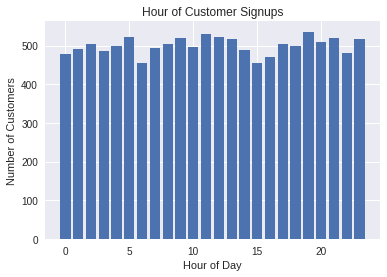

In [14]:
users['hour_of_creation'] = users.creation.dt.hour
counts = users.groupby('hour_of_creation').name.count()

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title('Hour of Customer Signups')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Customers');

del users['hour_of_creation']

In [15]:
# Stealing this code from fastai.tabular
# Would import it but getting IO Error, so here's the workaround

def make_date(df:pd.DataFrame, date_field:str):
    "Make sure `df[field_name]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

def add_datepart(df:pd.DataFrame, field_name:str, prefix:str=None, drop:bool=True, time:bool=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = prefix or re.sub('[Dd]ate$', '', field_name)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
    df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

users = add_datepart(users, 'creation')
users = add_datepart(users, 'last_session')

In [16]:
eng['time_stamp'] = pd.to_datetime(eng.time_stamp)
eng.sort_values('time_stamp', inplace=True)

# Get timestamps by day, as int for calcs
eng['time_stamp'] = eng.time_stamp.dt.floor('d').astype(np.int64)
#sort and remove duplicate days for a given user
eng = eng.sort_values(['user_id', 'time_stamp']).drop_duplicates()

# Find rolling-3-visit window for each visit
rolling_3_visits = eng.groupby('user_id')['time_stamp'].rolling(window=3)

# Count # of days across each rolling-3-visit window
days_count = pd.to_timedelta((rolling_3_visits.max()- rolling_3_visits.min())).dt.days

# Get unique user ids with a <= 7 day rolling-3-visit window
counts = set(days_count[days_count <= 7].index.get_level_values('user_id').to_list())

adopted = pd.DataFrame({'id': sorted(users.object_id)})
adopted['adopted'] = adopted.id.apply(lambda x: x in counts)

In [17]:
df = pd.merge(users, adopted, left_on='object_id', right_on='id')
df.head()

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,creationYear,...,last_sessionDayofyear,last_sessionIs_month_end,last_sessionIs_month_start,last_sessionIs_quarter_end,last_sessionIs_quarter_start,last_sessionIs_year_end,last_sessionIs_year_start,last_sessionElapsed,id,adopted
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,yahoo.com,2014,...,112,False,False,False,False,False,False,1398138810,1,False
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,gustr.com,2013,...,90,True,False,True,False,False,False,1396237504,2,True
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,gustr.com,2013,...,78,False,False,False,False,False,False,1363734892,3,False
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,yahoo.com,2013,...,142,False,False,False,False,False,False,1369210168,4,False
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,yahoo.com,2013,...,22,False,False,False,False,False,False,1358849660,5,False


In [18]:
df.invited_by_user_id.fillna(0, inplace=True);

In [19]:
domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df['domain'] = df.domain.apply(lambda x: x if x in domains else 'other')

In [20]:
del df['name']
del df['email']
df = pd.get_dummies(df, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 43 columns):
object_id                             12000 non-null int64
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
creationYear                          12000 non-null int64
creationMonth                         12000 non-null int64
creationWeek                          12000 non-null int64
creationDay                           12000 non-null int64
creationDayofweek                     12000 non-null int64
creationDayofyear                     12000 non-null int64
creationIs_month_end                  12000 non-null bool
creationIs_month_start                12000 non-null bool
creationIs_quarter_end                12000 non-null bool
creationIs_quarter_start              12000 non-null bool
creation

In [21]:
# Set up cross-validation to choose parameters

# Split into X and y
X = df.drop('adopted', axis='columns')
y = df['adopted']

# Do two-level train-test split: first to get the set-aside test set and a train_and_valid set
# Then to split train_and_valid into training and validation sets
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.2, random_state=42)

# model 
clf = RandomForestClassifier(n_estimators=50, n_jobs=4, random_state=42) 

# Parameters for grid search
param_grid = {'max_features': ['auto', 'log2', 10],
              'max_depth': [None, 1, 5, 10, 20]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='roc_auc')

grid.fit(X_train, y_train)

print('Best cv AUC: {:.2f}'.format(grid.best_score_)) # Best cv AUC: 0.99
print('Best validation set score: {:.2f}'.format(grid.score(X_valid, y_valid))) # Best validation set score: 0.99
print('Best parameters: ', grid.best_params_) # Best parameters: {'max_depth': None, 'max_features': 'auto'} 

Best cv AUC: 0.99
Best validation set score: 0.99
Best parameters:  {'max_depth': None, 'max_features': 'auto'}


In [22]:
# Using the parameters chosen, re-train with 1000 estimators using train and validation sets

model = RandomForestClassifier(n_estimators=1000, n_jobs=4, random_state=42)

model.fit(X_train, y_train)
valid_preds = model.predict(X_valid)

print('Training AUC: {:.2f}'.format(roc_auc_score(y_train, model.predict(X_train))))
print('Validation AUC: {:.2f}'.format(roc_auc_score(y_valid, valid_preds)))

Training AUC: 1.00
Validation AUC: 0.92


In [23]:
# Re-train using both train and validation sets for training, and compare to test set
# Really just validating what we believe to be true: test AUC should be around 0.92 as it was for validation AUC above

model = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=4, random_state=42)

model.fit(X_train_and_valid, y_train_and_valid)
test_preds = model.predict(X_test)

print('Training + Validation AUC: {:.2f}'.format(roc_auc_score(y_train_and_valid, model.predict(X_train_and_valid))))
print('Final Test AUC: {:.2f}'.format(roc_auc_score(y_test, test_preds)))
print('Final Test Accuracy: {:.2f}'.format(accuracy_score(y_test, test_preds)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, test_preds))

Training + Validation AUC: 0.94
Final Test AUC: 0.89
Final Test Accuracy: 0.96
Confusion Matrix:
[[2043   20]
 [  69  268]]


### Summary of Feature Importance

13.8% of all users are adopted users.

**Most of the importance of various features is focused on how recently the user logged in**, since 83% of adopted users
logged in in 2014. More importantly, of the users who logged in in 2014, 36.6% of them are adopted users - which is nearly 
three times the 13.8% adoption rate.  

**Simply put, the data provided does not give us a tremendous amount of information that is relevant to user adoption.**

Digging into what we do have from the data:
* Feature importance can be expressed as a percentage, since the importance of all features in our model add up to 1.
* The length of time since the user's last session is by far the most important feature, with a "score" of 24%.
* The year of the user's last session is the second-most important feature, at 11%.
* The third-most-important variable is the length of time since the user was created.
* The fourth- and fifth-most-important variables once again relate to the user's last session.

What may be more interesting to the business, **other variables like marketing drip, mailing list, and creation source all
have less than a 1% feature importance "score" in our model.**

In an attempt to get more useful information into the model, I added the email domain and things like day/time of day that
the user signed up; however, those variables didn't matter.

Other variables that might help us to understand user adoption better:
* Variables related to the user's use case -- are they using this product for personal use, professional use, etc.
* Variables related to the user's journey -- how/why they are prompted or invited to join with their friends.
* Variables related to product usage, once the user is logged in.

Two key data points are that **26% of users never logged in, and 25% of users only logged in once.** 
* The first statistic suggests that the account creation/login process is too difficult, and that prospective users may 
not see a compelling case to use the product in the first place.
* The second statistic suggests that new users either don't see an immediate compelling value from their first login, or
they find the interface difficult to use.
* Taken together, these statistics also suggest that mapping the user journey along with expected value propositions for
different key user segments could be a useful exercise.

In [24]:
# Get feature_importances, match up to data columns, and sort descending
imps = model.feature_importances_

importances = pd.DataFrame(columns=['Feature', 'Importance'],
                           data=(sorted(list(zip(X.columns, imps)), key=lambda tup: tup[1],  reverse=True)))

importances['Importance'] = round(importances.Importance, 2)
importances.set_index('Importance', inplace=True, drop=True)
importances

,Feature
Importance,
0.24,last_sessionElapsed
0.11,last_sessionYear
0.09,creationElapsed
0.08,last_sessionDayofyear
0.07,last_sessionWeek
0.07,creationDayofyear
0.06,creationWeek
0.05,creationMonth
0.05,last_sessionMonth
